In [1]:
import random
import pandas as pd
import numpy as np
from collections import defaultdict

from Python_Scripts import OrderedCategorySystem as OCS
from Python_Scripts import generate_plots as plots
from Python_Scripts import order_analyses as analyses


## Setup

In [2]:
F =  [12, 13, 15, 14, 16, 18, 17, 19, 20]
B =  [20, 19, 17, 18, 16, 14, 15, 13, 12]
M1 =  [16, 17, 15, 18, 14, 19, 13, 20, 12]
M2 = [16, 15, 17, 14, 18, 13, 19, 12, 20]

NEW = [i for i in range(9, 24)]
ALL = NEW + [1, 3, 29, 31]

SHIFT = 3
DISTRACTORS = [1, 3, 29, 31]

conditions = {1: "2LF", 2: "2LM", 3: "2LB", 4: "2CF", 5: "2CM", 6: "2CB", 7: "2RF", 8: "2RM",
              9: "2RB", 10: "3LF", 11: "3LM", 12: "3LB", 13: "3CF", 14: "3CM", 15: "3CB", 16: "3RF",
              17: "3RM", 18: "3RB", 19: "2LA", 20: "2CA", 21: "2RA", 22: "3LA", 23: "3CA", 24: "3RA"}

ITEMS = ['I09', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16', 'I17', 'I18', 'I19', 'I20', 'I21', 'I22', 'I23']

LEFT = ITEMS[:9]
CENTRE = ITEMS[3:12]
RIGHT = ITEMS[6:]

LOCS = [('L', LEFT),
        ('C', CENTRE), 
        ('R', RIGHT)]
ORDERS = [('f', 0, [1, 2, 3, 4, 5, 6, 7, 8]),
          ('m', 4, [0, 1, 2, 3, 5, 6, 7, 8]),
          ('b', 8, [0, 1, 2, 3, 4, 5, 6, 7])]

item_space = [i for i in range(1, 32)]

## Functions

In [3]:
def get_item_set(order, loc):
    if order in ['F', 'B', 'M']: # Sequence
        if order == 'F':
            items = F
        elif order == 'B':
            items = B
        else: 
            items = random.choice([M1, M2])
        random.shuffle(DISTRACTORS)
        if loc == 'L':
            items = [i-SHIFT for i in items]
        elif loc == 'R':
            items = [i+SHIFT for i in items]
        return items[0:1] + DISTRACTORS[0:1] + items[1:4] + DISTRACTORS[1:2] + items[4:5] + DISTRACTORS[2:3] + items[5:8] + DISTRACTORS[3:4] + items[8:9]
    else: # All at once 
        items = F
        if loc == 'L':
            items = [i-SHIFT for i in items]
        elif loc == 'R':
            items = [i+SHIFT for i in items]
        final_set = items + DISTRACTORS
        random.shuffle(final_set)
        return final_set

def simulate_trials(conditions, softmax, temp=1.0, alpha=0.0):
    trials = []
    D, item_hash = OCS.get_distance_mat(item_space)
    treeCache = defaultdict(lambda: None)
    for i in range(len(conditions)):
        code = conditions[i]
        d, l, o = list(code)
        items = get_item_set(o, l)
        if d == '2':
            syst = OCS.CategorySystem(item_hash, 'Python_Scripts/BaseSystems/tree2D.json')
        else:
            syst = OCS.CategorySystem(item_hash, 'Python_Scripts/BaseSystems/tree3D.json')
        if softmax:
            score, cat_choices = OCS.greedy_categorizer_softmax(syst, items, D, treeCache, temp, alpha)
        else:
            score, cat_choices = OCS.greedy_categorizer(syst, items, D, treeCache)
        cat_choices['SCORE'] = score
        cat_choices['DEPTH'] = int(d)
        cat_choices['LOC'] = l
        cat_choices['ORDER'] = o.lower()
        cat_choices['P_ID'] = f's{i:03d}'
        cat_choices['POOL'] = 'simulated'
        cat_choices['STIMULI'] = 'simulated'
        trials.append(cat_choices)
        if i % 1000 == 0:
            print(f'{i+1} iteration(s) completed')
    df = pd.DataFrame.from_dict(trials)
    df = df[['P_ID', 'DEPTH', 'LOC', 'ORDER'] + [i for i in range(9, 24)] + [1, 3, 29, 31] + ['STIMULI', 'POOL', 'SCORE']]
    df.rename(columns={i:f'I{i:02}' for i in range(9, 24)}, inplace=True)
    df.rename(columns={1: 'I01', 3: 'I03', 29: 'I29', 31: 'I31'}, inplace=True)
    return df

## Simulations
Load trial types

In [4]:
allParticipants = pd.read_csv('Results/participant_data.csv')
allParticipants =  allParticipants[(allParticipants['ATTEMPTS'] < 3) & (allParticipants['TOTAL_ERRORS'] < 4)]
participants = allParticipants['P_ID'].tolist()

trials_df = pd.read_csv('Results/trial_data.csv')    
trials_df = trials_df[trials_df['P_ID'].isin(participants)][['DEPTH', 'LOC', 'ORDER']]

codes = trials_df["DEPTH"].astype(str) + trials_df["LOC"] + trials_df['ORDER'].str.upper()
codes = codes.tolist()

### Best fitting CKMM model
Softmax with T = 1.0, alpha = 0.15

1 iteration(s) completed
1001 iteration(s) completed


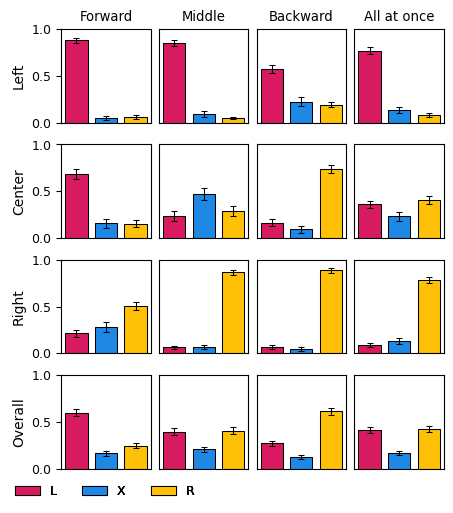

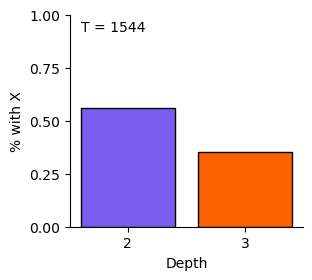

In [21]:
N = 1544
random.seed(1)
np.random.seed(1)
df_sm_full = simulate_trials(codes, True, temp=1.0, alpha=0.15)
df_sm = analyses.get_level2_cat_stats(df_sm_full, ITEMS)
plots.order_effects_plot(df_sm, fname='Figures/simulated_powerpoint.pdf', figsize=(4.4, 4.75), legend=True, show_counts=False)
plots.new_category_plot(df_sm, fname='Figures/best_simulated_X_by_depth.pdf', figsize=(3, 2.75))

In [22]:
print(round(df_sm[['DEPTH', 'HAS_X']].groupby(['DEPTH']).mean().reset_index(), 4))


   DEPTH   HAS_X
0      2  0.5596
1      3  0.3536


Percentage of trials where all are added to the same category: 27.7%
Mean: 0.671
Median items: 0.75
Mode: 1.0


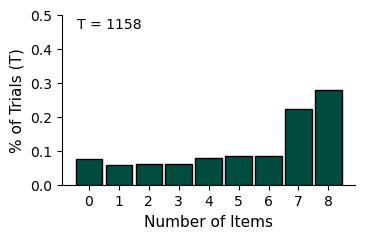

In [23]:
seq_df, _ = analyses.get_seq_data(df_sm, LOCS, ORDERS)
mean_prob = seq_df['PROP_SAME'].mean()
median_prob = seq_df['PROP_SAME'].median()
mode_probs = seq_df['PROP_SAME'].mode().values
all_same = seq_df[seq_df['PROP_SAME'] == 1].count()['PROP_SAME'] / seq_df.shape[0]
print(f'Percentage of trials where all are added to the same category: {round(all_same*100, 1)}%')

print(f'Mean: {mean_prob:.3f}')
print(f'Median items: {median_prob}')
print(f'Mode: {','.join([f'{m}' for m in mode_probs])}')

plots.same_as_dist(seq_df, figsize=(3.75, 2.5), fname='Figures/best_simulated.pdf')

In [24]:
left_f, left_m, left_b =  analyses.get_jsds(df_sm, 'L')
right_f, right_m, right_b =  analyses.get_jsds(df_sm, 'R')

table = pd.DataFrame({'': ['Left', 'Right'],
        'Forward': [round(left_f,3), round(right_f,3)],
        'Middle': [round(left_m,3), round(right_m, 3)],
        'Backward': [round(left_b, 3), round(right_b,3)]})

print(table.to_string(index=False))

       Forward  Middle  Backward
 Left    0.112   0.075     0.155
Right    0.205   0.080     0.114


In [19]:
round(df_sm_full[['LOC', 'SCORE']].groupby(['LOC']).max())

,SCORE
LOC,
C,2507.0
L,2563.0
R,2563.0


In [ ]:
# df_sm_full.to_csv('Results/sim_trial_data_determ.csv', index=None)

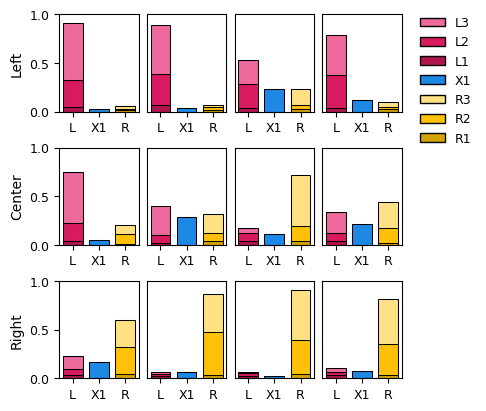

In [20]:
# df_sm_full = pd.read_csv('Results/sim_trial_data.csv')
# grouped_df = trialDF[trialDF['DEPTH'] == 3].groupby(['LOC', 'ORDER']).mean(numeric_only=True).reset_index()
# grouped_df

import copy
from matplotlib import pyplot as plt
from matplotlib.patches import Patch


L_colors = ['#B0144E', '#D81B60', '#EE6A9C']  
R_colors = ['#D4A106', '#FFC107', '#FFE082']

lev3_df = copy.deepcopy(df_sm_full[df_sm_full['DEPTH'] == 3])
lev3_df['PROP_L1'] = lev3_df[lev3_df[ITEMS] == 'L1'].count(axis=1)/9
lev3_df['PROP_L2'] = lev3_df[lev3_df[ITEMS] == 'L2'].count(axis=1)/9
lev3_df['PROP_L3'] = lev3_df[lev3_df[ITEMS] == 'L3'].count(axis=1)/9
lev3_df['PROP_X1'] = lev3_df[lev3_df[ITEMS] == 'X1'].count(axis=1)/9
lev3_df['PROP_R1'] = lev3_df[lev3_df[ITEMS] == 'R1'].count(axis=1)/9
lev3_df['PROP_R2'] = lev3_df[lev3_df[ITEMS] == 'R2'].count(axis=1)/9
lev3_df['PROP_R3'] = lev3_df[lev3_df[ITEMS] == 'R3'].count(axis=1)/9
fig, axes = plt.subplots(3, 4, figsize=(4, 4), constrained_layout=True)
grouped_df = lev3_df.groupby(['LOC', 'ORDER']).mean(numeric_only=True).reset_index() 
orders = ['Forward', 'Middle', 'Backward', 'All at once']
locations = ['Left', 'Center', 'Right', 'Overall']
for i in range(3):
    for j in range(4):
            ax = axes[i, j]
            ax.tick_params(axis='both', which='major', labelsize=9)
            order = orders[j].lower()[0]
            loc = locations[i][0]
            vals = grouped_df[
                (grouped_df['LOC'] == loc) & (grouped_df['ORDER'] == order)
            ][[
                'PROP_L1', 'PROP_L2', 'PROP_L3','PROP_X1','PROP_R1', 'PROP_R2', 'PROP_R3'
            ]].values[0]

            # x positions
            x_labels = ['L', 'X1', 'R']
            x_pos = range(len(x_labels))

            # ---- stacked L ----
            ax.bar(x_pos[0], vals[0], color=L_colors[0], edgecolor='black', width=0.75, linewidth=0.75)
            ax.bar(x_pos[0], vals[1], bottom=vals[0], color=L_colors[1], edgecolor='black', width=0.75, linewidth=0.75)
            ax.bar(x_pos[0], vals[2], bottom=vals[0] + vals[1], color=L_colors[2], edgecolor='black', width=0.75, linewidth=0.75)

            ax.bar(x_pos[1], vals[3], color='#1E88E5', edgecolor='black', width=0.75, linewidth=0.75)

            ax.bar(x_pos[2], vals[4], color=R_colors[0], edgecolor='black', width=0.75, linewidth=0.75)
            ax.bar(x_pos[2], vals[5], bottom=vals[4], color=R_colors[1], edgecolor='black', width=0.75, linewidth=0.75)
            ax.bar(x_pos[2], vals[6], bottom=vals[4] + vals[5], color=R_colors[2], edgecolor='black', width=0.75, linewidth=0.75)

            ax.set_xticks(x_pos)
            ax.set_xticklabels(x_labels)
            if j == 0:
                ax.set_ylabel(f'{locations[i]}', fontsize=10)
                ax.set_yticks([0.0, 0.5, 1.0])
            else:
                ax.set_yticks([])
            ax.set_ylim(0, 1)


legend_elements = [
    Patch(facecolor='#EE6A9C', edgecolor='black', label='L3'),
    Patch(facecolor='#D81B60', edgecolor='black', label='L2'),
    Patch(facecolor='#B0144E', edgecolor='black', label='L1'),
    Patch(facecolor='#1E88E5', edgecolor='black', label='X1'),
    Patch(facecolor='#FFE082', edgecolor='black', label='R3'),
    Patch(facecolor='#FFC107', edgecolor='black', label='R2'),
    Patch(facecolor='#D4A106', edgecolor='black', label='R1'),
]

fig.legend(
    handles=legend_elements,
    loc='upper center',
    ncol=1,
    fontsize=9,
    frameon=False,
    bbox_to_anchor=(1.1, 1)
)

4.23
Mean: 0.425
Median items: 0.375
Mode: 0.0


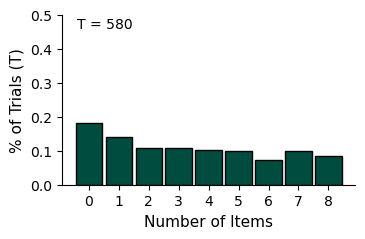

In [13]:
import numpy as np
dfs_by_loc = []
for loc, items in LOCS:
    loc_df = lev3_df[lev3_df['LOC'] == loc]
    items = np.array(items)
    seq_dfs = []
    long_dfs = []
    for lab, first_idx, other_idx in ORDERS:
        first = items[first_idx]
        other = items[other_idx].tolist()
        item_subset = loc_df[loc_df['ORDER'] == lab]
        same_as_first = item_subset[[first] + other].apply(lambda x: x[other] == x[first], axis=1)*1
        same_as_first['PROP_SAME'] = same_as_first[other].sum(axis=1) / 8
        same_as_first['FIRST_IT'] = first
        subseq_df = pd.concat([item_subset[['P_ID', 'STIMULI', 'POOL', 'DEPTH', 'LOC', 'ORDER']], item_subset[first], same_as_first], axis=1)
        subseq_df.rename(columns={first: 'FIRST'}, inplace=True)
        long_seq = subseq_df.melt(id_vars = ['P_ID', 'STIMULI', 'POOL', 'DEPTH', 'LOC', 'ORDER', 'FIRST', 'FIRST_IT'], value_vars=other, var_name='ITEM', value_name='SAME')
        long_seq.rename(columns={first: 'FIRST_CAT'}, inplace=True)
        subseq_df.rename(columns={other[i] : f'OTH_{i+1}' for i in range(len(other))}, inplace=True)
        seq_dfs.append(subseq_df)
        long_dfs.append(long_seq)
    dfs_by_loc.append(pd.concat(seq_dfs))
seq_df_3 = pd.concat(dfs_by_loc).reset_index().drop('index', axis=1)


plots.same_as_dist(seq_df_3, figsize=(3.75, 2.5), fname='Figures/seq3.jpg')

mean_prob = seq_df_3['PROP_SAME'].mean()
median_prob = seq_df_3['PROP_SAME'].median()
mode_probs = seq_df_3['PROP_SAME'].mode().values
all_same = seq_df_3[seq_df_3['PROP_SAME'] == 1].count()['PROP_SAME'] / seq_df.shape[0]
print(f'{round(all_same*100, 2):.2f}')

print(f'Mean: {mean_prob:.3f}')
print(f'Median items: {median_prob}')
print(f'Mode: {','.join([f'{m}' for m in mode_probs])}')